# Spacy test

## Import neccesary libraries

In [2]:
import spacy
from spacy import displacy
from spacy.matcher import Matcher
import pandas as pd
pd.set_option('display.max_colwidth', None)
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
import re
import numpy as np
from pprint import pprint
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.decomposition import PCA
import seaborn as sns
# from wikipedia2vec import Wikipedia2Vec

In [3]:
# use pre-trained corpus to help tokenise words
nlp = spacy.load('en_core_web_sm')

## Terms explained
Document -> a bunch of texts <br>
Corpus -> a bunch of documents <br>
Vectors -> a mathematically convenience representation of a document (a bunch of textx) <br>
Models -> an algorithm for transforming vectors from one representation to another <br>

# load data

In [43]:
netflixDf = pd.read_csv('finalDataset_v2.csv', usecols=['title','type','description','genres','originals'])

In [8]:
# movie = pd.read_csv('nMovieRg.csv', usecols=['title','description'])
# tvshow = pd.read_csv('nTvshowRg.csv', usecols=['title','description'])

In [10]:
# netflix_df = movie.append(tvshow, ignore_index=True)

### Each description is a "doc". The collection of these "docs" is the "corpus".

In [44]:
corpus = netflixDf.description.values.tolist() #list of docs

In [45]:
def tokenise(doc):
    """Use spacy as the nlp object to tokenise each doc"""
    return [token.text for token in nlp(doc)]

In [46]:
corpus_with_tkdocs = [tokenise(doc) for doc in corpus]

In [47]:
# mapping out the title and each description. so later on i can search 
title_text = dict(zip(netflixDf['title'].str.lower().tolist(), corpus_with_tkdocs))
# lower the title (easy for search)

### Use pre-trained google news model to train my w2v model
It might take a few seconds to train

In [8]:
# path = "GoogleNews-vectors-negative300.bin"
# w2v = KeyedVectors.load_word2vec_format(path, binary=True)

In [9]:
# Use wiki2vec
MODEL_FILE = "enwiki_20180420_300d.txt"
w2v = KeyedVectors.load_word2vec_format(MODEL_FILE)

In [10]:
# this is one way to get each title's vector representation
# more investagtion is needed later.

def get_vectors(first_map, second_map):
    first_vec  = dict()
    for title, description in first_map.items():
        temp = list()
        for element in description: #element = tokenised words
            try:
                temp.append(second_map[element]) #secondmap is w2v model which should have a responding word vecotr for the tokenise word
            except KeyError:
                pass
        first_vec[title] = np.mean(temp, axis=0)
    
    return first_vec

In [11]:
def get_most_similar(lookup_id, title_vec):

    sim = list()
    lookup_map = title_vec
    subject_map = title_vec 
        
    for uid, vec in lookup_map.items():
        thisSim = cosine_similarity(vec.reshape(1, -1), subject_map[lookup_id].reshape(1, -1))
        sim.append((uid, thisSim[0][0]))

    return sorted(sim, key=lambda x: x[1], reverse=True)

In [48]:
title_vec = get_vectors(title_text, w2v)

In [27]:
# d = {}
# for t in netflixDf.title.str.lower().tolist():
#     if t not in d.keys():
#         d[t] = 1
#     else:
#         d[t] += 1
# for k, v in d.items():
#     if v != 1:
#         print(k, v)

In [30]:
get_most_similar('house of cards', title_vec)[1:11]

[('versailles', 0.98725194),
 ('godless', 0.9870885),
 ('how to get away with murder', 0.98603266),
 ('orange is the new black', 0.98569435),
 ("marvel's daredevil", 0.98551905),
 ('troy: fall of a city', 0.9849536),
 ('hostages (2013)', 0.9848928),
 ('lilyhammer', 0.9848332),
 ('bates motel', 0.984747),
 ('reign', 0.9847238)]

In [12]:
get_most_similar('house of cards', title_vec)[1:11]

[('bloodline', 0.9467709),
 ('reign', 0.9466064),
 ('broadchurch', 0.9440308),
 ('peaky blinders', 0.9435389),
 ('the end of the f***ing world', 0.9429343),
 ('hostages', 0.9425726),
 ('collateral', 0.9425075),
 ('breaking bad', 0.94222677),
 ('sherlock', 0.94206876),
 ('orange is the new black', 0.9417874)]

In [ ]:
def sim_title_description(title, dataset):
    """Return the title description"""
    filt = dataset['title'].str.lower() == title
    return dataset.loc[filt]['description'].values.tolist()[0]

In [ ]:
def dscp_comparison(org, dataset, vec):
    
    org = org.lower()
    org_dscp = dataset.loc[dataset['title'].str.lower() == org]['description'].values.tolist()[0]
    print(f"The input title name is '{org}'\n")
    print(org_dscp, '\n')
    sim = get_most_similar(org, vec)[1:11]
    
    for i in range(len(sim)):
        title = sim[i][0]
        print(f"The most similiar No.{i+1} is '{title}'\n")
        print(sim_title_description(title, dataset),'\n')

In [ ]:
title = "Star Wars: The Rise of Skywalker (Episode IX)".lower()
dscp_comparison(title, data6k, title_vec6k)

In [ ]:
title = ("Star Wars: The Rise of Skywalker (Episode IX)").lower()
sim = get_most_similar(title, title_vec6k)[1:11]
pprint(sim)

# Display scatterplot PCA

In [28]:
def display_pca_scatterplot(titles, vec):
    
    title_vectors = np.array([vec[title] for title in titles])
    twodim = PCA().fit_transform(title_vectors)[:,:2]
    plt.figure(figsize=(12,12))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='grey')
#     for title, (x,y) in zip(titles, twodim):
#         plt.text(x+0.05, y+0.05, title)
    plt.show()

In [31]:
# titles = np.random.choice(netflix_df['title'].values, size = 1000).tolist()
titles = netflix_df['title'].values.tolist()
titles = [title.lower() for title in titles]

In [132]:
netflix_df[netflix_df.duplicated()]

,title,description
650,The Burial of Kojo,A man is trapped in a mine shaft by his vengeful brother while his daughter embarks on a magical journey to rescue him.The Burial of Kojo featuring Ama K. Abebrese and Joe Addo is streaming with subscription on Netflix. It's a drama and mystery movie with a very high Rotten Tomatoes (critics) score of 100% and an average IMDb audience rating of 6.4 (505 votes).
653,A Futile and Stupid Gesture,"The National Lampoon name became globally recognized after the monumental success of Animal House—but before the glory days, it was a scrappy yet divinely subversive magazine and radio show that introduced the world to comedic geniuses like Bill Murray, Chevy Chase, John Belushi, and Gilda Radner. The driving force behind National Lampoon was Doug Kenney (Will Forte), and his truly wild and crazy story unfolds in A Futile and Stupid Gesture from Harvard to Hollywood to Caddyshack and beyond.A Futile and Stupid Gesture featuring Will Forte and Domhnall Gleeson is streaming with subscription on Netflix. It's a biography and comedy movie with an average Rotten Tomatoes (critics) score of 61% and a better than average IMDb audience rating of 6.8 (12,621 votes)."
663,Andaz Apna Apna,"Two slackers competing for the affections of an heiress inadvertently become her protectors from an evil criminal.Andaz Apna Apna featuring Aamir Khan and Salman Khan is streaming with subscription on Netflix, streaming with subscription on Prime Video, available for rent or purchase on iTunes, and 2 others. It's an action & adventure and comedy movie with a high IMDb audience rating of 8.2 (47,824 votes)."


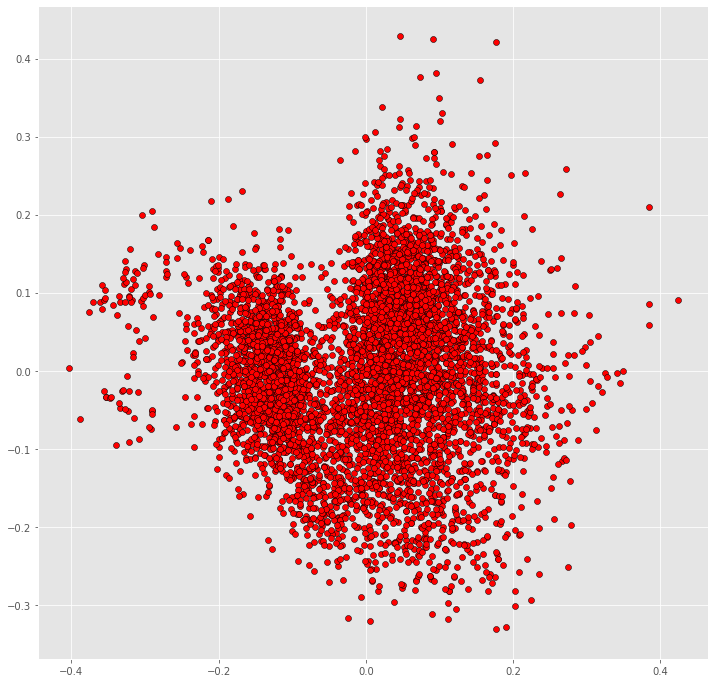

In [32]:
display_pca_scatterplot(titles, title_vec)

#  Try T-SNE

In [49]:
values = np.array(list(title_vec.values()))
labels = list(title_vec.keys())

In [50]:
tsne = TSNE(n_components=2, random_state=1)
tsne_values = tsne.fit_transform(values)

In [105]:
# Add dim1, dim2 to final dataset
netflixDf['dim1'] = tsne_values[:,0]
netflixDf['dim2'] = tsne_values[:,1]

In [51]:
tsne_data = np.vstack((tsne_values.T, labels)).T

In [55]:
tsne_df = pd.DataFrame(data=tsne_data, columns=['Dim1','Dim2','title'])

In [56]:
tsne_df.shape

(5830, 3)

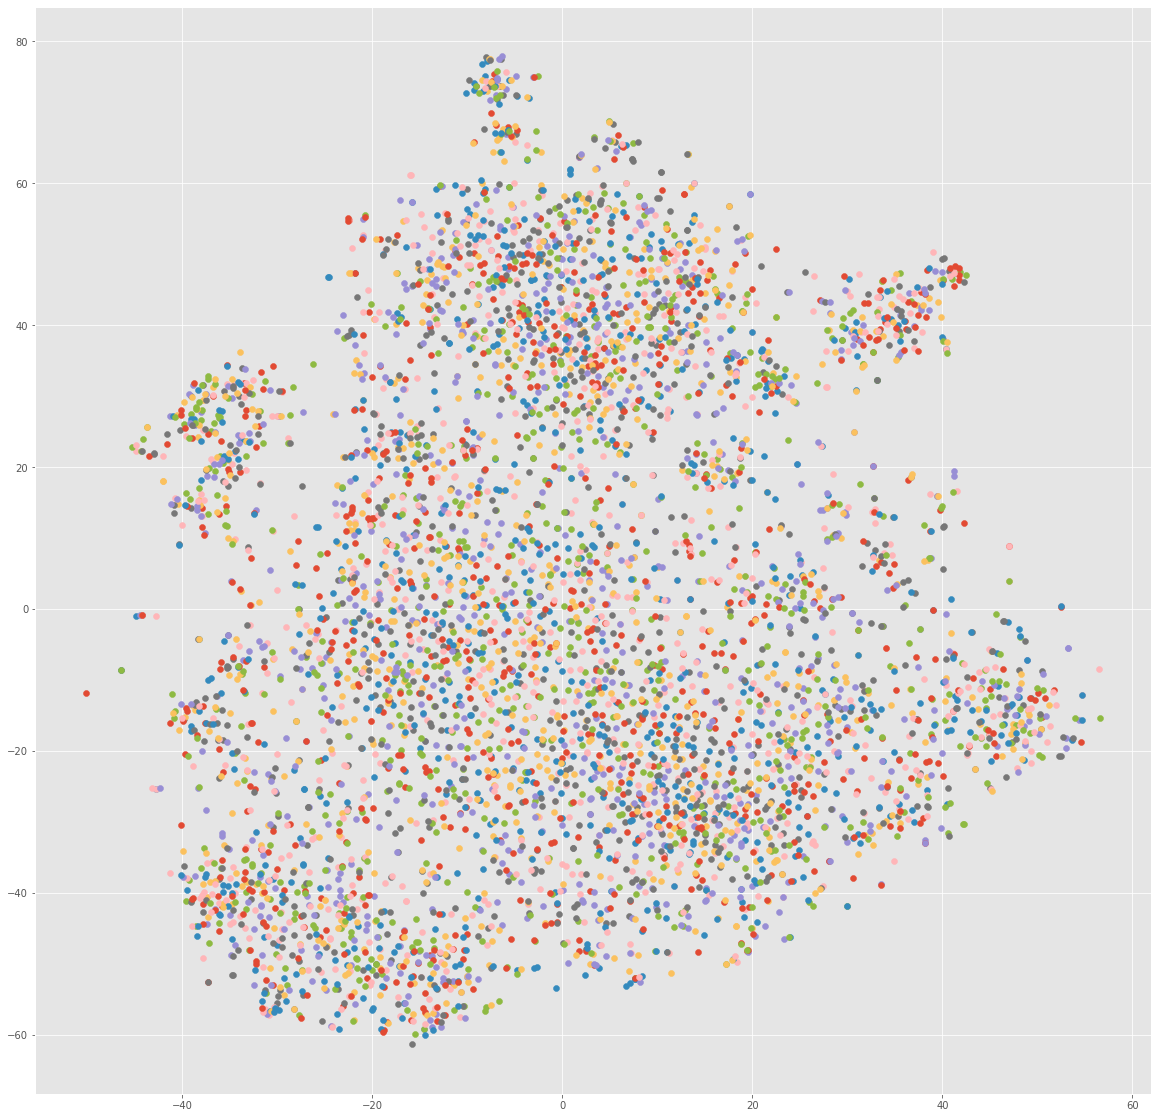

In [69]:
x, y = [], []
for item in tsne_values:
    x.append(item[0])
    y.append(item[1])
    
plt.figure(figsize=(20, 20))
for ix, _ in enumerate(x):
    plt.scatter(x[ix], y[ix])
plt.show()

# K-means k=11

In [57]:
from sklearn.cluster import KMeans

In [106]:
kmean_df = netflixDf[['dim1','dim2']]

In [107]:
kmeans = KMeans(n_clusters=11)
kmeans.fit(kmean_df)

KMeans(n_clusters=11)

In [108]:
labels = kmeans.predict(kmean_df)
centroids = kmeans.cluster_centers_

In [109]:
kmean_df.columns

Index(['dim1', 'dim2'], dtype='object')

In [115]:
netflixDf.head()

,title,genres,description,type,originals,dim1,dim2,label
0,1000 mabrouk,"comedy,drama,fantasy,thriller","About a man who wakes up one morning to discover that the day repeats, a carbon copy of the day before, trapping him in an inescapable vicious circle. This man has a dream to live for 100 years, however he is living for one day only and that day keep repeating to show him the negative and positive things in his life.1000 Mabrouk featuring Ahmed Helmy and Laila Ezz El Arab is streaming with subscription on Netflix. It's a comedy and drama movie with a better than average IMDb audience rating of 7.4 (3,427 votes).",movie,0,-17.916454,-7.860606,7
1,1000 rupee note,drama,"Poor Parobudhi receives a thousand rupee note from a politician at an election rally. However, she has no idea about the kind of trouble she just got into. Ek Hazarachi Note is an encouraging tale of humanity against money.1000 Rupee Note featuring Sandeep Pathak is streaming with subscription on Netflix, streaming with subscription on Kanopy, available for rent or purchase on iTunes, and 4 others. It's a drama movie with a high Rotten Tomatoes (critics) score of 80% and a better than average IMDb audience rating of 7.3 (331 votes).",movie,0,-45.276974,5.362171,6
2,100 days of loneliness,"documentary,drama",An extraordinary and touching tale about a man alone in the nature.100 Days of Loneliness featuring José Díaz is streaming with subscription on Netflix. It's a documentary and drama movie with a better than average IMDb audience rating of 6.7 (267 votes).,movie,0,-46.630272,33.423096,0
3,100 meters,"comedy,drama,biography","Based on the incredibly true story of a Spanish man with Multiple Esclorosis who tried to finish an Iron-Man: 3,8km swimming, 180km cycling and 42 running. And he was told that he could not make 100 meters.100 Meters featuring Dani Rovira and Alexandra Jiménez is streaming with subscription on Netflix. It's a biography and comedy movie with a better than average IMDb audience rating of 7.5 (4,648 votes).",movie,0,-14.654765,10.810891,8
4,10 days in sun city,"comedy,action-and-adventure,romance","A potpourri of love, drama, passion and culture, ""10 Days in Sun City"" is a comedy-drama that sees Akpos on another ‘adventure’, this time, to South Africa, with his girlfriend Bianca.10 Days In Sun City featuring Adesua Etomi and Yvonne Jegede is streaming with subscription on Netflix, streaming with subscription on Prime Video, free on Tubi, and 1 other. It's an action & adventure and comedy movie with a less than average IMDb audience rating of 5.4 (33 votes).",movie,0,-52.851971,23.744921,6


# mark out the originals 

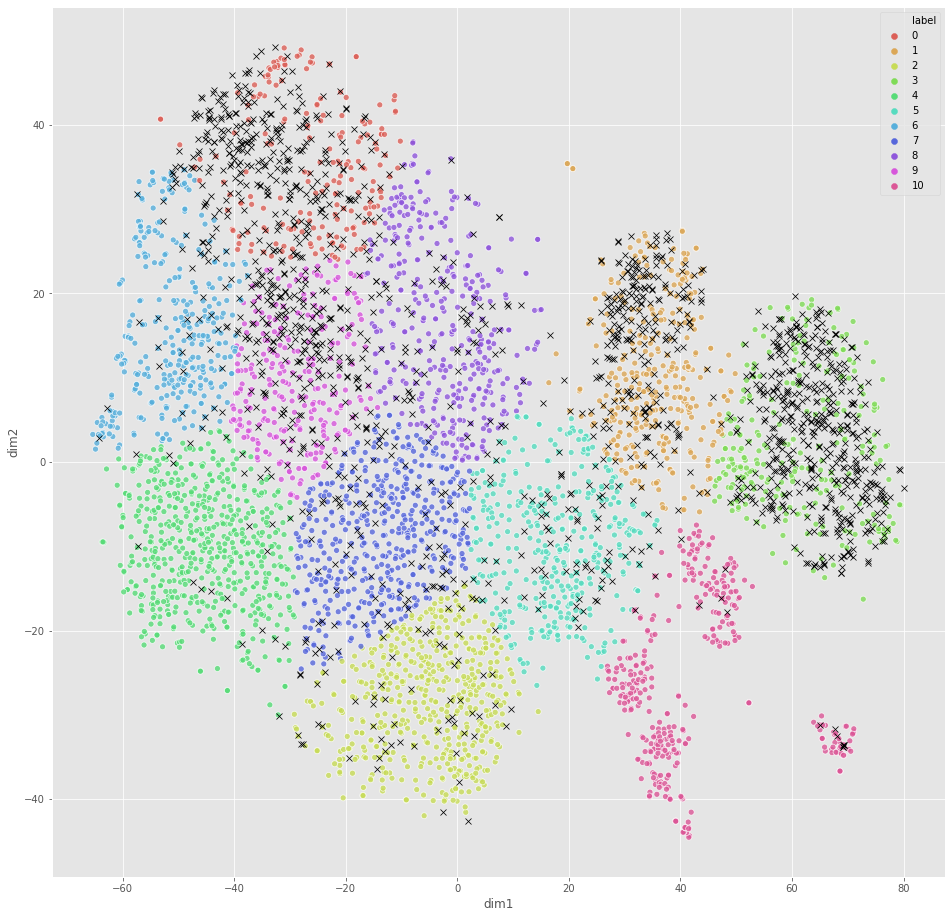

In [198]:
is_org = netflixDf.loc[netflixDf['originals']==1]
not_org = netflixDf.loc[netflixDf['originals']==0]

plt.figure(figsize=(16,16))
sns.scatterplot(
    x="dim1", y="dim2",
    hue="label",
    palette=sns.color_palette("hls", 11),
    data=not_org,
    legend="full",
    alpha=0.8
)
sns.scatterplot(x='dim1',y='dim2', data=is_org, marker='x', legend='full', alpha=1, color='black')
plt.savefig('originals.png')
plt.show()

In [122]:
centroids

array([[-30.027822 ,  35.697582 ],
       [ 34.50397  ,  12.104368 ],
       [ -5.361636 , -28.427122 ],
       [ 63.25422  ,   2.448741 ],
       [-45.049805 , -10.219986 ],
       [ 17.884226 ,  -9.739764 ],
       [-50.566708 ,  16.682947 ],
       [-13.691748 ,  -8.8229265],
       [ -2.3414152,  16.469294 ],
       [-28.486504 ,  11.388072 ],
       [ 43.568287 , -26.83584  ]], dtype=float32)

# Mark the centroid

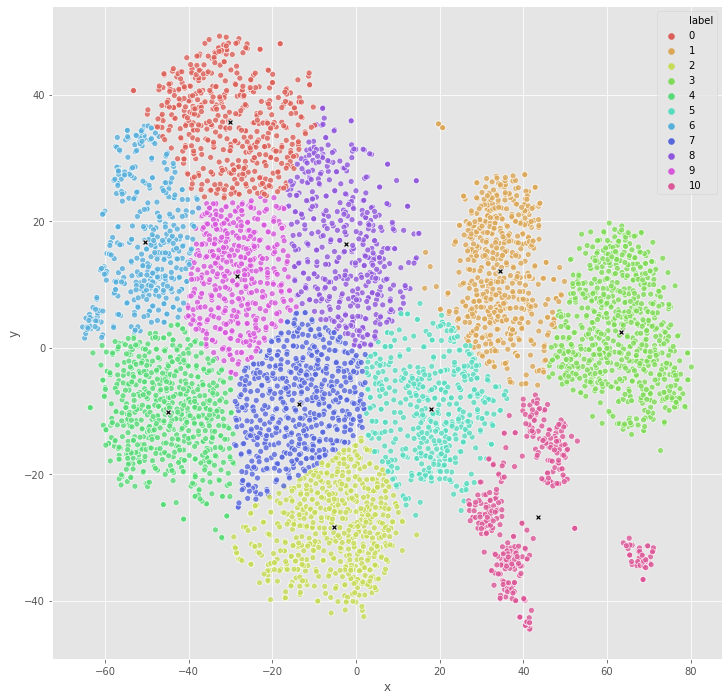

In [197]:
cent = pd.DataFrame()
cent['x'] = centroids[:,0]
cent['y'] = centroids[:,1]

plt.figure(figsize=(12,12))
sns.scatterplot(
    x="dim1", y="dim2",
    hue="label",
    palette=sns.color_palette("hls", 11),
    data=netflixDf,
    legend="full",
    alpha=0.8
)
sns.scatterplot(x='x',y='y', data=cent, marker='X', legend='full', alpha=1, color='black')
plt.savefig('withCentroids.png')
plt.show()

# Mark the most watched films and series

THE FIGURES
Netflix’s top movies
By viewership, October 2018-September 2019
Bird Box 80 million
Murder Mystery 73 million
Triple Frontier 52 million
The Perfect Date 48 million
Tall Girl 41 million
The Highwaymen 40 million
Secret Obsession 40 million
Always Be My Maybe 32 million
Otherhood 29 million
Fyre 20 million

Netflix’s top television series
By viewership, October 2018-September 2019
Stranger Things 64 million
The Umbrella Academy 45 million
La Casa de Papel 44 million
You 40 million
Sex Education 40 million
Our Planet 33 million
Unbelievable 32 million
Dead to Me 30 million
When They See Us 25 million
Elite 20 million

In [209]:
list_of_most_watched = [
    'bird box',
    'Murder Mystery',
    'Triple Frontier',
    'The Perfect Date',
    'Tall Girl',
    'The Highwaymen',
    'Secret Obsession',
    'Always Be My Maybe',
    'Otherhood',
    'FYRE: The Greatest Party That Never Happened',
    'Stranger Things',
    'The Umbrella Academy',
    'Money Heist',
    'You',
    'Sex Education',
    'Our Planet',
    'Unbelievable',
    'Dead to Me',
    'When They See Us',
    'Elite',
]
list_of_most_watched = [t.lower() for t in list_of_most_watched]

In [210]:
netflixDf.loc[netflixDf['title'].isin(list_of_most_watched)]

,title,genres,description,type,originals,dim1,dim2,label
195,always be my maybe,"romance,comedy","Reunited after 15 years, famous chef Sasha and hometown musician Marcus feel the old sparks of attraction but struggle to adapt to each other's worlds.Always Be My Maybe featuring Ali Wong and Randall Park is streaming with subscription on Netflix. It's a comedy and romance movie with a high Rotten Tomatoes (critics) score of 89% and a better than average IMDb audience rating of 6.8 (41,794 votes).",movie,1,-26.908163,28.029625,0
495,bird box,"thriller,drama,science-fiction,mystery,horror","Five years after an ominous unseen presence drives most of society to suicide, a survivor and her two children make a desperate bid to reach safety.Bird Box featuring Sandra Bullock and Trevante Rhodes is streaming with subscription on Netflix. It's a drama and horror movie with an average Rotten Tomatoes (critics) score of 63% and an average IMDb audience rating of 6.6 (261,754 votes).",movie,1,-28.131763,15.975264,9
1131,fyre: the greatest party that never happened,documentary,"He promised supermodels and yachts, but delivered tents and cheese sandwiches. How one man engineered a music festival disaster.FYRE: The Greatest Party That Never Happened featuring Billy McFarland and Ja Rule is streaming with subscription on Netflix. It's a documentary movie with a very high Rotten Tomatoes (critics) score of 91% and a better than average IMDb audience rating of 7.2 (34,078 votes).",movie,1,-41.788902,33.066399,0
2110,murder mystery,"comedy,crime,mystery,action-and-adventure,romance,thriller","After attending a gathering on a billionaire's yacht during a European vacation, a New York cop and his wife become prime suspects when he's murdered.Murder Mystery featuring Adam Sandler and Jennifer Aniston is streaming with subscription on Netflix. It's an action & adventure and comedy movie with a less than average Rotten Tomatoes (critics) score of 44% and an average IMDb audience rating of 6.0 (91,255 votes).",movie,1,-27.017052,15.864262,9
2292,otherhood,comedy,"Three suburban moms travel to New York City to visit their sons.Otherhood featuring Angela Bassett and Patricia Arquette is streaming with subscription on Netflix. It's a comedy movie with a very low Rotten Tomatoes (critics) score of 29% and an average IMDb audience rating of 6.1 (8,428 votes).",movie,1,-34.927193,24.891504,0
2671,secret obsession,"drama,thriller,mystery","Newlywed Jennifer is brutally attacked at a dark rest stop. While healing from her injuries, she can’t recall anything from her past, including the ordeal. Her husband, Russell , is just thankful she’s alive and eager to get her home. As he reintroduces her to their secluded mountain estate, Detective Page pursues Jennifer’s assailant — his own daughter went missing and was never found. The same fate now awaits Jennifer, unless someone realizes that her loving caretaker is actually her captor.Secret Obsession featuring Brenda Song and Mike Vogel is streaming with subscription on Netflix. It's a drama and mystery movie with a low Rotten Tomatoes (critics) score of 36% and a low IMDb audience rating of 4.3 (16,562 votes).",movie,1,0.335388,-37.956367,2
2908,tall girl,"comedy,drama,romance","Jodi, the tallest girl in her high school, has always felt uncomfortable in her own skin. But after years of slouching, being made fun of, and avoiding attention at all costs, Jodi finally decides to find the confidence to stand tall.Tall Girl featuring Ava Michelle and Sabrina Carpenter is streaming with subscription on Netflix. It's a comedy and drama movie with a less than average Rotten Tomatoes (critics) score of 44% and a less than average IMDb audience rating of 5.2 (15,472 votes).",movie,1,-33.101845,18.648500,9
3134,the highwaymen,"crime,drama,thriller,biography,mystery","In 1934, Frank Hamer and Manny Gault, two former Texas Rangers, are commissioned to put an end to the wave of vicious crimes perpetrated by Bonnie Parker and Clyde

In [211]:
for i in list_of_most_watched:

    if i not in most_watched_df.title.tolist():
        print(i)

fyre: the greatest party that never happened


In [226]:
most_watched_df.loc[most_watched_df['label']==0]['dim1']

195    -26.908163
1131   -41.788902
2292   -34.927193
Name: dim1, dtype: float32

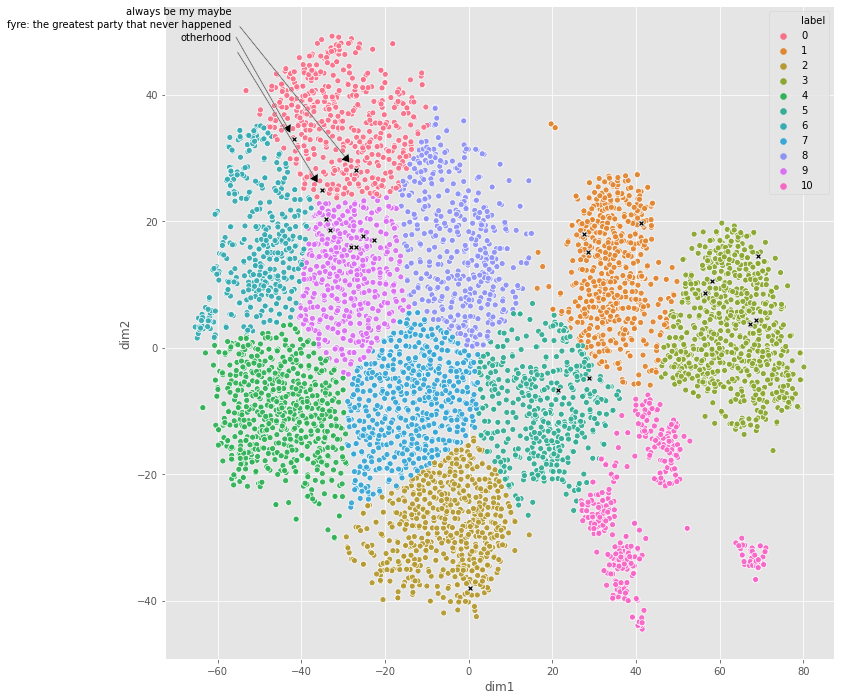

In [249]:
most_watched_df = netflixDf.loc[netflixDf['title'].isin(list_of_most_watched)]
others_df = netflixDf.loc[~netflixDf['title'].isin(list_of_most_watched)]

def annotate(label):
    x = most_watched_df.loc[most_watched_df['label']==label]['dim1'].tolist()
    y = most_watched_df.loc[most_watched_df['label']==label]['dim2'].tolist()
    titles = most_watched_df.loc[most_watched_df['label']==label]['title'].tolist()
    return(x,y,titles)

plt.figure(figsize=(12,12))
sns.scatterplot(
    x="dim1", y="dim2",
    hue = "label",
    palette = sns.color_palette("husl", 11),
    data = others_df,
    legend = "full",
    alpha = 0.95
)
sns.scatterplot(x='dim1',y='dim2', data = most_watched_df, marker='X', legend='full', alpha=1, color='black')

x0, y0, t0 = annotate(0)
x1, y1, t1 = annotate(1)
x2, y2, t2 = annotate(2)
x3, y3, t3 = annotate(3)
x5, y5, t5 = annotate(5)
x9, y9, t9 = annotate(9)

for i in range(len(x0)):
    plt.annotate(t0[i],
                xy=(x0[i],y0[i]), xycoords='data',
                xytext = (0.1,1-(0.02*i)),
                textcoords='axes fraction',
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=10, headlength=8),
                horizontalalignment='right', verticalalignment='top')


# plt.savefig('mstwatch.png')
plt.show()

### Who are these centroids? Ans: centroids are not titles. <br> They are the centre point of the cluster.

In [137]:
# save the file
# netflixDf.to_csv('df_with_dim_labs.csv')

In [121]:
netflixDf.groupby(by='label').sum().originals

label
0     303
1     236
2      59
3     476
4      22
5      80
6      58
7      90
8      78
9     201
10     15
Name: originals, dtype: int64

# Determine the k value using elbow method

In [159]:
wcss = []

for i in range(1,51):
    kmeans = KMeans(i)
    kmeans.fit(kmean_df)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

In [160]:
for i in range(50):
    print(wcss[i])

8779545.222514957
3764874.624795971
2760745.9079735046
1974562.458438188
1446304.5811497201
1231246.5838115008
1059429.001063853
924597.2723999929
806832.7065705848
720551.0389383478
646390.0347854284
590082.9265615318
539100.9523191781
500471.11573635926
461367.6588332883
433363.25715598656
405687.39642942237
379602.7730141888
355793.24357053504
336022.5576118132
317478.29636057996
300559.2064283058
284920.0504275722
270561.5036779367
257385.68424923354
246384.6706794552
238448.9077987433
229500.20988610122
219847.94796679294
212993.98481736454
207273.5180145101
200498.6523855212
195178.25716043232
188902.09170493856
183469.79315108864
177658.2968825022
173245.0869617404
167359.42528523892
163422.35858979338
157617.44262880573
155555.2764454725
152555.68672978604
148623.84937171196
143341.70109676005
141452.21797290622
139238.02213964178
135592.59074083704
131834.49198319123
129435.25400412038
126579.9131260138


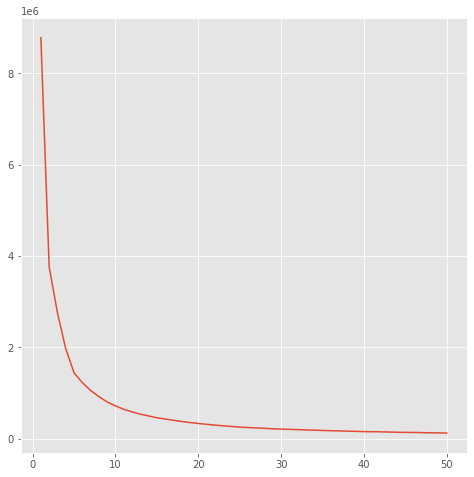

In [161]:
number_clusters = range(1,51)
plt.figure(figsize=(8,8)
plt.plot(number_clusters, wcss)
plt.show()

# Count genres in each label and select featured titles

In [141]:
def labelDf(n):
    return netflixDf.loc[netflixDf['label']== n]

In [143]:
label0 = labelDf(0)
label1 = labelDf(1)
label2 = labelDf(2)
label3 = labelDf(3)
label4 = labelDf(4)
label5 = labelDf(5)
label6 = labelDf(6)
label7 = labelDf(7)
label8 = labelDf(8)
label9 = labelDf(9)
label10 = labelDf(10)
label11 = labelDf(11)

In [144]:
def count_genres(labelDf):
    """Given a labelDf, the function will produce a sorted dictionary containing genres counts"""
    genres_count = dict()

    for genres in labelDf.genres:
        if type(genres) == float:
            if 'not listed' not in genres_count.keys():
                genres_count['not listed'] = 1 
            else:
                genres_count['not listed'] += 1 
        else:
            g = genres.split(',')
            for i in range(len(g)):
                if g[i] not in genres_count.keys():
                    genres_count[g[i]] = 1
                else:
                    genres_count[g[i]] += 1
    
    genres_count = sorted(genres_count.items(), key=lambda item: item[1], reverse=True)
    
    return genres_count

In [145]:
allDfGenres = count_genres(netflixDf)
genres0 = count_genres(label0)
genres1 = count_genres(label1)
genres2 = count_genres(label2)
genres3 = count_genres(label3)
genres4 = count_genres(label4)
genres5 = count_genres(label5)
genres6 = count_genres(label6)
genres7 = count_genres(label7)
genres8 = count_genres(label8)
genres9 = count_genres(label9)
genres10 = count_genres(label10)
genres11 = count_genres(label11)

In [161]:
g = [list(i) for i in count_genres(netflixDf)]
li_g = [g[j][0] for j in range(len(g))]

In [162]:
genre_countDf = pd.DataFrame()
genre_countDf['genres'] = li_g

In [165]:
allDfGenres

[('drama', 2754),
 ('comedy', 2149),
 ('action-and-adventure', 1330),
 ('thriller', 1088),
 ('documentary', 1002),
 ('romance', 964),
 ('mystery', 918),
 ('crime', 809),
 ('family', 706),
 ('fantasy', 646),
 ('animation', 613),
 ('science-fiction', 519),
 ('horror', 406),
 ('history', 252),
 ('biography', 242),
 ('not listed', 236),
 ('children', 227),
 ('stand-up-and-talk', 212),
 ('musical', 189),
 ('reality', 182),
 ('sport', 157),
 ('anime', 139),
 ('lgbtq', 63),
 ('food', 48),
 ('game-show', 41),
 ('travel', 33),
 ('cult', 22),
 ('home-and-garden', 18),
 ('independent', 13)]

In [169]:
print(allDfGenres[0][0])
print(allDfGenres[0][1])
print(len(allDfGenres))

drama
2754
29


In [182]:
def dictionary(genres_count):
    gen = [x[0] for x in genres_count]
    count = [y[1] for y in genres_count]
    d = dict(zip(gen, count))
    for g in li_g:
        if g not in d.keys():
             d[g] = 0
    return d

In [185]:
dictionary(genres0)

29

In [172]:
genre_countDf = genre_countDf.set_index('genres')

In [173]:
genre_countDf['all'] = 0

In [174]:
genre_countDf

,all
genres,
drama,0
comedy,0
action-and-adventure,0
thriller,0
documentary,0
romance,0
mystery,0
crime,0
family,0


In [150]:
def topN(genres, N):
    """input a 'count_genres()' object to get top n genres"""
    topn = list(zip([gen[0] for gen in genres][0:N],[x for x in [gen[1] for gen in genres][0:N]]))
    return topn

# top5g0 = list(zip([gen[0] for gen in genres0][0:5],[round((x/label0.shape[0]),4) for x in [gen[1] for gen in genres0][0:5]]))
# # [gen[0] for gen in genres0][0:5]
# # [(x/label0.shape[0]) for x in [gen[1] for gen in genres0][0:5]]
# top5g1 = list(zip([gen[0] for gen in genres1][0:5],[round((x/label1.shape[0]),4) for x in [gen[1] for gen in genres1][0:5]]))
# top5g2 = list(zip([gen[0] for gen in genres2][0:5],[round((x/label2.shape[0]),4) for x in [gen[1] for gen in genres2][0:5]]))
# top5g3 = list(zip([gen[0] for gen in genres3][0:5],[round((x/label3.shape[0]),4) for x in [gen[1] for gen in genres3][0:5]]))
# top5g4 = list(zip([gen[0] for gen in genres4][0:5],[round((x/label4.shape[0]),4) for x in [gen[1] for gen in genres4][0:5]]))


In [152]:
top10g0 = topN(genres0, 10)
top10g0

[('comedy', 287),
 ('documentary', 199),
 ('stand-up-and-talk', 156),
 ('drama', 90),
 ('biography', 35),
 ('romance', 24),
 ('history', 23),
 ('musical', 23),
 ('mystery', 14),
 ('not listed', 14)]

In [133]:
top10Df = pd.DataFrame()
top10Df['g0'] = topN(label0, genres0, 10)
top10Df['g1'] = topN(label1, genres1, 10)
top10Df['g2'] = topN(label2, genres2, 10)
top10Df['g3'] = topN(label3, genres3, 10)
top10Df['g4'] = topN(label4, genres4, 10)


In [134]:
top10Df

,g0,g1,g2,g3,g4
0,"(comedy, 0.47)","(drama, 0.5146)","(drama, 0.4254)","(drama, 0.5293)","(drama, 0.4679)"
1,"(drama, 0.4028)","(comedy, 0.3416)","(comedy, 0.3338)","(comedy, 0.3774)","(comedy, 0.3202)"
2,"(documentary, 0.2322)","(romance, 0.2307)","(action-and-adventure, 0.2599)","(action-and-adventure, 0.3681)","(action-and-adventure, 0.2275)"
3,"(thriller, 0.1493)","(action-and-adventure, 0.1861)","(animation, 0.2216)","(thriller, 0.313)","(documentary, 0.2073)"
4,"(action-and-adventure, 0.1327)","(thriller, 0.1825)","(family, 0.1847)","(mystery, 0.2833)","(crime, 0.1835)"
5,"(stand-up-and-talk, 0.1327)","(documentary, 0.1445)","(documentary, 0.1765)","(romance, 0.1934)","(romance, 0.1486)"
6,"(romance, 0.1295)","(mystery, 0.1336)","(crime, 0.1683)","(crime, 0.1688)","(fantasy, 0.1468)"
7,"(mystery, 0.1177)","(family, 0.1219)","(fantasy, 0.1614)","(family, 0.1459)","(thriller, 0.1431)"
8,"(crime, 0.1011)","(fantasy, 0.1073)","(children, 0.1436)","(fantasy, 0.1179)","(animation, 0.1376)"
9,"(biography, 0.0608)","(crime, 0.0978)","(science-fiction, 0.1341)","(horror, 0.1094)","(science-fiction, 0.1321)"


In [122]:
print(f"There are {label0.shape[0]} titles in label 0,\n the top 5 genres are:\n {top5g0} \n")
print(f"There are {label1.shape[0]} titles in label 1,\n the top 5 genres are:\n {top5g1} \n")
print(f"There are {label2.shape[0]} titles in label 2,\n the top 5 genres are:\n {top5g2} \n")
print(f"There are {label3.shape[0]} titles in label 3,\n the top 5 genres are:\n {top5g3} \n")
print(f"There are {label4.shape[0]} titles in label 4,\n the top 5 genres are:\n {top5g4} \n")

There are 1266 titles in label 0,
 the top 5 genres are:
 [('comedy', 0.47), ('drama', 0.4028), ('documentary', 0.2322), ('thriller', 0.1493), ('action-and-adventure', 0.1327)] 

There are 1370 titles in label 1,
 the top 5 genres are:
 [('drama', 0.5146), ('comedy', 0.3416), ('romance', 0.2307), ('action-and-adventure', 0.1861), ('thriller', 0.1825)] 

There are 731 titles in label 2,
 the top 5 genres are:
 [('drama', 0.4254), ('comedy', 0.3338), ('action-and-adventure', 0.2599), ('animation', 0.2216), ('family', 0.1847)] 

There are 1179 titles in label 3,
 the top 5 genres are:
 [('drama', 0.5293), ('comedy', 0.3774), ('action-and-adventure', 0.3681), ('thriller', 0.313), ('mystery', 0.2833)] 

There are 1090 titles in label 4,
 the top 5 genres are:
 [('drama', 0.4679), ('comedy', 0.3202), ('action-and-adventure', 0.2275), ('documentary', 0.2073), ('crime', 0.1835)] 



In [101]:
netflixDf.groupby(by='label').sum()

,originals
label,
0,466
1,161
2,334
3,68
4,234


In [137]:
def search(df, name):
    """filter the name out of the given dataframe"""
    return df.loc[df['title'].str.lower()==name]

In [138]:
search(netflixDf, 'the last kingdom')

,title,type,description,genres,originals,label
4721,The Last Kingdom,tvshow,"A show of heroic deeds and epic battles with a thematic depth that embraces politics, religion, warfare, courage, love, loyalty and our universal search for identity. Combining real historical figures and events with fictional characters, it is the story of how a people combined their strength under one of the most iconic kings of history in order to reclaim their land for themselves and build a place they call home.The Last Kingdom featuring Alexander Dreymon and Emily Cox has one or more episodes streaming with subscription on Netflix, available for purchase on iTunes, available for purchase on Google Play, and 3 others. It's an action & adventure and drama show with 40 episodes over 4 seasons. The Last Kingdom is still airing with no announced date for the next episode or season. It has a very high Rotten Tomatoes (critics) score of 91% and a high IMDb audience rating of 8.4 (72,484 votes).","action-and-adventure,history,romance,drama",0,2


In [139]:
search(netflixDf, 'breaking bad')

,title,type,description,genres,originals,label
788,Breaking Bad,tvshow,"When Walter White, a New Mexico chemistry teacher, is diagnosed with Stage III cancer and given a prognosis of only two years left to live. He becomes filled with a sense of fearlessness and an unrelenting desire to secure his family's financial future at any cost as he enters the dangerous world of drugs and crime.Breaking Bad featuring Bryan Cranston and Aaron Paul has one or more episodes streaming with subscription on Netflix, available for purchase on iTunes, available for purchase on Google Play, and 3 others. It's a crime and drama show with 62 episodes over 5 seasons. Breaking Bad is no longer running and has no plans to air new episodes or seasons. It has a very high Rotten Tomatoes (critics) score of 96% and a very high IMDb audience rating of 9.5 (1,366,001 votes).","crime,drama,thriller",0,4


In [140]:
search(netflixDf, 'our planet')

,title,type,description,genres,originals,label
3383,Our Planet,tvshow,"Experience our planet's natural beauty and examine how climate change impacts all living creatures in this ambitious documentary of spectacular scope.Our Planet featuring David Attenborough has one or more episodes streaming with subscription on Netflix. It's a documentary show with 8 episodes over 1 season. Our Planet is no longer running and has no plans to air new episodes or seasons. It has a very high Rotten Tomatoes (critics) score of 93% and a very high IMDb audience rating of 9.3 (26,515 votes).",documentary,1,4


In [144]:
search(netflixDf, 'the witcher')

,title,type,description,genres,originals,label
5042,The Witcher,tvshow,"Geralt of Rivia, a mutated monster-hunter for hire, journeys toward his destiny in a turbulent world where people often prove more wicked than beasts.The Witcher featuring Henry Cavill and Freya Allan has one or more episodes streaming with subscription on Netflix. It's an action & adventure and drama show with 8 episodes over 1 season. The Witcher is still airing with no announced date for the next episode or season. It has a better than average Rotten Tomatoes (critics) score of 67% and a high IMDb audience rating of 8.3 (258,425 votes).","drama,action-and-adventure,fantasy,horror,mystery",1,2


In [145]:
top10byNetflix = ['stranger things', 'the witcher', 'the umbrella academy', 'dead to me','you',
                  'when they see us','unbelievbal', 'sex education', '13 reasons why', 'raising dion']

In [146]:
search(netflixDf, '13 reasons why')

,title,type,description,genres,originals,label
35,13 Reasons Why,tvshow,"After a teenage girl's perplexing suicide, a classmate receives a series of tapes that unravel the mystery of her tragic choice.13 Reasons Why featuring Dylan Minnette and Grace Saif has one or more episodes streaming with subscription on Netflix, available for purchase on Google Play, available for purchase on Prime Video, and 2 others. It's a drama and mystery show with 49 episodes over 4 seasons. 13 Reasons Why is no longer running and has no plans to air new episodes or seasons. It has a low Rotten Tomatoes (critics) score of 31% and a high IMDb audience rating of 7.7 (242,295 votes).","drama,mystery,thriller",0,4


In [165]:
# get index of netflix originals
org_ix = netflixDf.loc[netflixDf['originals']==1].index.tolist()

Text(0.8, 0.95, 'the last kingdom')

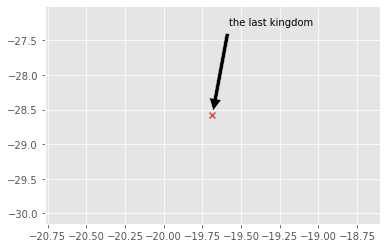

In [179]:
plt.scatter(x[4721],y[4721], marker='x')
plt.annotate('the last kingdom',
            xy=(x[4721],y[4721]), xycoords='data',
            xytext=(0.8, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')


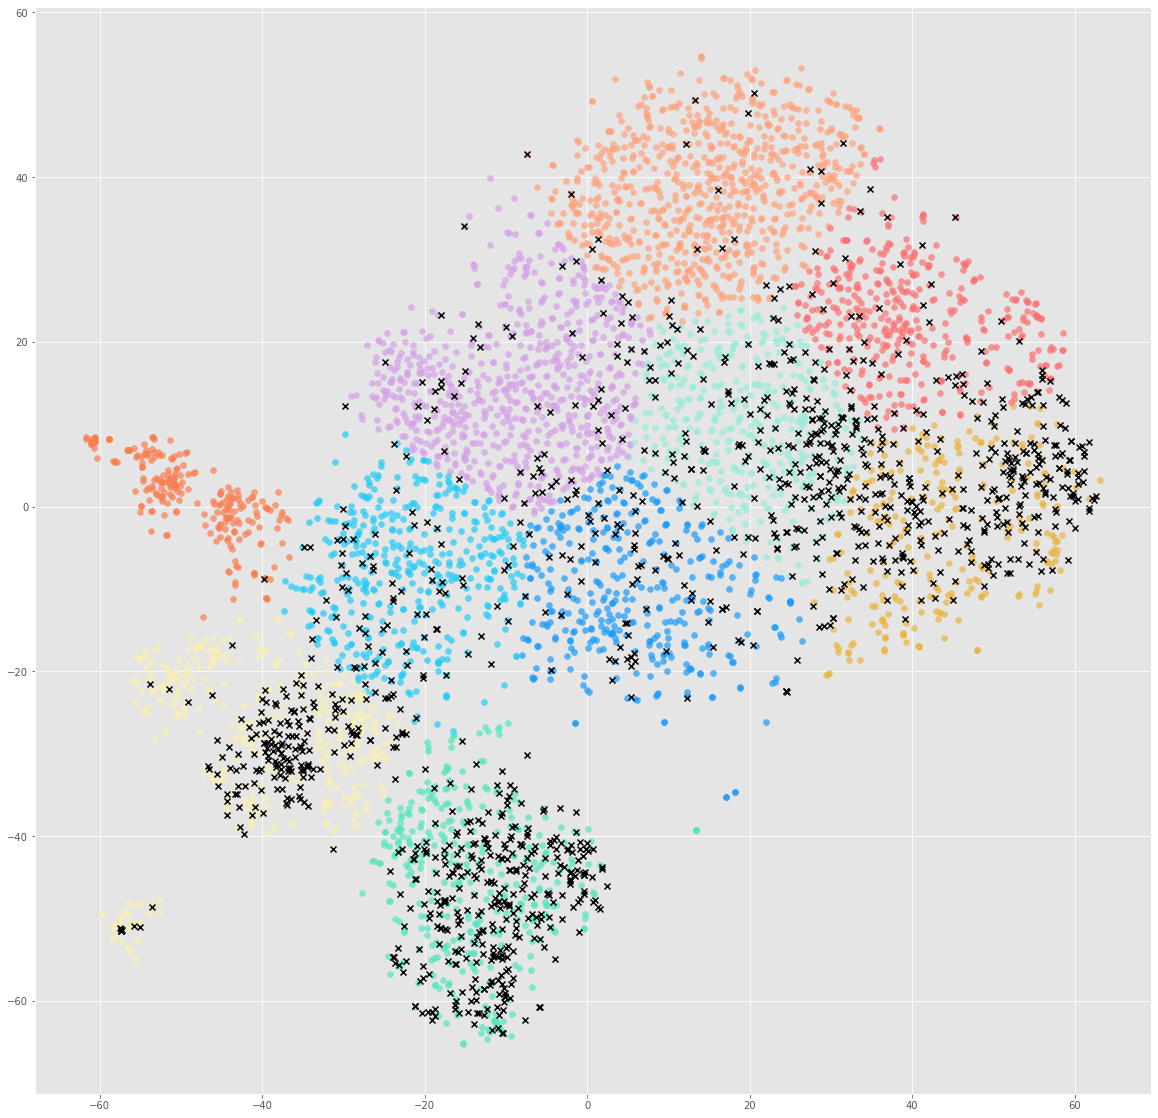

In [173]:
# k = 10
colors = ['#FEA47F','#25CCF7','#EAB543','#55E6C1','#F97F51','#1B9CFC','#F8EFBA','#9AECDB','#D6A2E8','#FD7272']
color_dict = dict()
for ix in range(10):
    color_dict[str(ix)] = colors[ix]
    
color = list()
for label in labels:
    color.append(color_dict[str(label)])

x, y = [], []
for item in tsne_values:
    x.append(item[0])
    y.append(item[1])
    
plt.figure(figsize=(20, 20))
for ix, _ in enumerate(x):
    if ix not in org_ix:
        plt.scatter(x[ix], y[ix], color=color[ix], alpha=0.7)
        
for ix, _ in enumerate(x):
    if ix in org_ix:
        plt.scatter(x[ix], y[ix], color='black', marker='x')


plt.show()

In [175]:
search(netflixDf, 'the last kingdom').index

Int64Index([4721], dtype='int64')

Extraction – 90 million views*
Spenser Confidential – 85 million views*
6 Underground – 83 million views*
Bird Box – 80 million views
Murder Mystery – 73 million views
The Witcher – 72 million views*
Money Heist (Season 4) – 65 million views*
Tiger King (Limited Series) – 64 million views*
You (Season 2) – 54 million views*
Triple Frontier – 52 million views
The Perfect Date – 48 million views
Tall Girl – 41 million views

In [191]:
search(netflixDf, 'Tall Girl'.lower())

,title,type,description,genres,originals,label
4304,Tall Girl,movie,"Jodi, the tallest girl in her high school, has always felt uncomfortable in her own skin. But after years of slouching, being made fun of, and avoiding attention at all costs, Jodi finally decides to find the confidence to stand tall.Tall Girl featuring Ava Michelle and Sabrina Carpenter is streaming with subscription on Netflix. It's a comedy and drama movie with a less than average Rotten Tomatoes (critics) score of 44% and a less than average IMDb audience rating of 5.2 (15,385 votes).","comedy,drama,romance",1,0
